In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt

from mlgreens import data
from mlgreens.models import MCAE

In [2]:
root = "/Users/mhenderson/Documents/Projects/structwake/"
dat_path = root + "data/Greens_Data.h5"
model_path = root + "models/mcae-{:02d}.h5"
rseed = 314159
split = 0.9

In [3]:
p_masks = np.linspace(.4, .6, 11)
patch_sizes = np.array([[i,i] for i in [20, 25, 50]])
G_data = data.GreensData(dat_path)
_, test_data = data.split_data(G_data, split, seed=rseed)

Lc = G_data.attrs["Lc"]
a = G_data.attrs["a"]
n_m, n_lam = G_data.attrs["n_modes"]
n_modes = n_m * n_lam

In [4]:
n_models = 6
models = []
archives = []
for i in range(n_models):
    mpath = model_path.format(i+1)
    models.append(MCAE.load_model(mpath))
    archives.append({})
    with h5py.File(mpath.replace(".h5", "_archive.h5")) as archive:
        for lab in ["training", "validation"]:
            archives[-1][lab] = archive[lab][()]

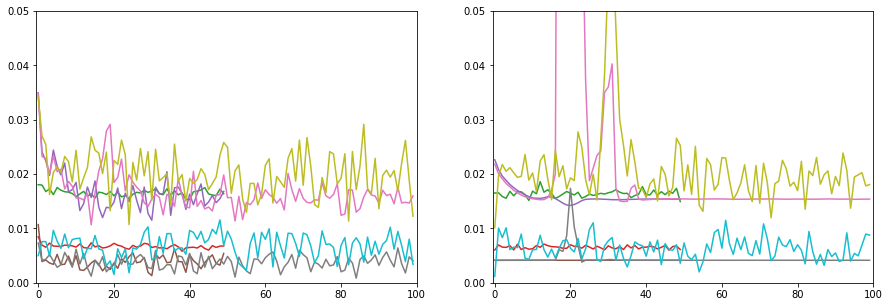

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
for i in range(n_models):
    axs[0].plot(archives[i]["training"])
    axs[1].plot(archives[i]["validation"])
for ax in axs: ax.axis([-.5, 100, 0, .05])

In [16]:
#
rID = np.random.choice(len(test_data))
G = test_data[rID]
attrs = test_data.get_attrs(rID)

#
patch_size = np.array([25,25])
G_patches = data.patch2D(G, patch_size)

# Mask data, keeping visible patches
pmask = 0.5
G_vis, G_hid, vIDs, hIDs = data.mask_data(G_patches, pmask, mask_val=None)

In [17]:
G_pred = np.zeros((n_models,) + G.shape)
for n in range(n_models):
    Gp, _ = models[n].process(G_vis, vIDs, hIDs)
    G_pred[n] = data.unpatch2D(Gp, G.shape[-2:])

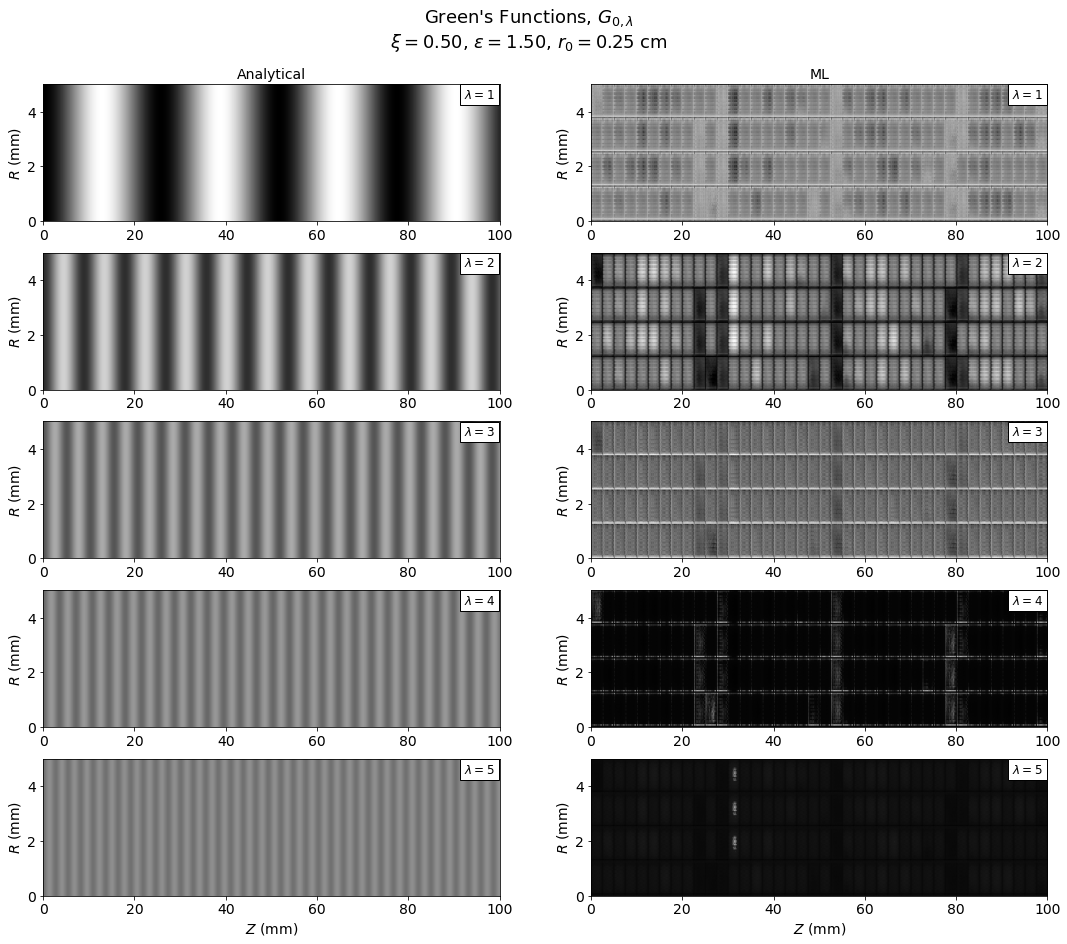

In [22]:
#
mode = 0
model = 5
ex = [0., Lc*10., 0., attrs["xi"]*a*10.]
plot_args = {
    "cmap": 'gray',
    "origin": 'lower',
    "extent": ex,
    "aspect": .3*ex[1]/ex[-1],
    "vmin": G.min(),
    "vmax": G.max(),
}

#
fig, axs = plt.subplots(n_lam, 2, figsize=(18, 5*n_m))
fig.suptitle(
    r"Green's Functions, $G_{:s}$".format("{"+"{:d}".format(mode)+",\lambda}")+
    "\n"+r"$\xi={:.2f}$, $\epsilon={:.2f}$, $r_0={:.2f}$ cm".format(attrs["xi"], attrs["epsilon"], attrs["r0"]),
    fontsize=18, y=.95
)
axs[0,0].set_title(r"Analytical", fontsize=14)
axs[0,1].set_title(r"ML", fontsize=14)
for m in range(n_lam):
    mID = mode * n_lam + m
    axs[m,0].imshow(G[mID], **plot_args)
    axs[m,1].imshow(G_pred[model, mID], **plot_args)
    for ax in axs[m]:
        ax.set_ylabel(r"$R$ (mm)", fontsize=14)
        ax.tick_params(labelsize=14)
        lam_label = ax.text(.99*ex[1], .97*ex[3], r"$\lambda={:d}$".format(m+1), color='k', fontsize=12, va='top', ha='right')
        lam_label.set_bbox(dict(facecolor='white', alpha=1.))
for ax in axs[-1]: ax.set_xlabel(r"$Z$ (mm)", fontsize=14)